In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
# load mask labelled points
labelled_points = np.load("mask.npz")["arm_keypoints"]

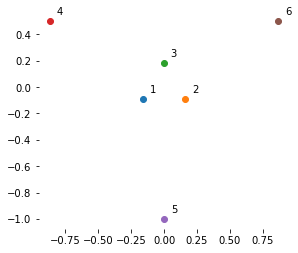

In [3]:
def euclidean_distance(point1, point2):
    """
    Calculate the euclidean distance between two points
    """
    return np.linalg.norm(point1 - point2)

arm_length = 1.0
arm_width = arm_length * np.mean([np.mean([
    euclidean_distance(labelled_points[i][0],labelled_points[i][1]),
    euclidean_distance(labelled_points[i][1],labelled_points[i][2]),
    euclidean_distance(labelled_points[i][2],labelled_points[i][0])
]) / np.mean([
    euclidean_distance(labelled_points[i][3],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][4],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][5],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3)
]) for i in range(len(labelled_points))])

reward_distance = 0.8
origin = np.array([0.0, 0.0])

# get three corners of a triangle
k1 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+2*np.pi/3), np.sin(np.pi/2+2*np.pi/3)])
k2 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+4*np.pi/3), np.sin(np.pi/2+4*np.pi/3)])
k3 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2), np.sin(np.pi/2)])

# get the endpoints of the arm
k4 = origin + arm_length * np.array([np.cos(np.pi/6+2*np.pi/3), np.sin(np.pi/6+2*np.pi/3)])
k5 = origin + arm_length * np.array([np.cos(np.pi/6+4*np.pi/3), np.sin(np.pi/6+4*np.pi/3)])
k6 = origin + arm_length * np.array([np.cos(np.pi/6), np.sin(np.pi/6)])

# plot the triangles
for i,k in enumerate([k1, k2, k3, k4, k5, k6]):
    plt.plot(k[0], k[1], 'o')
    plt.text(k[0] + 0.05, k[1] + 0.05, str(i+1))

plt.gca().set_aspect('equal')
plt.box()
plt.show()

reference_points = np.array([k1, k2, k3, k4, k5, k6])

In [4]:
from skimage.transform import estimate_transform, AffineTransform

estimated_transforms = []
for i in range(len(labelled_points)):
    # get the points
    points = labelled_points[i]
    # get the affine transform
    transform = estimate_transform("affine", points, reference_points)
    # add to the list
    estimated_transforms.append(transform)

[1. 0. 2.]


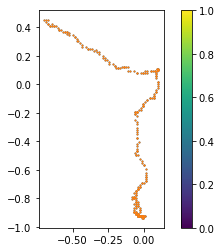

[2. 0. 1.]


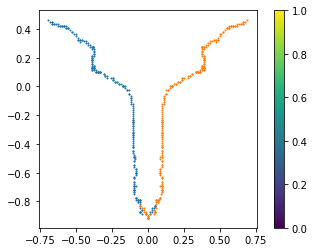

[2. 1. 0.]


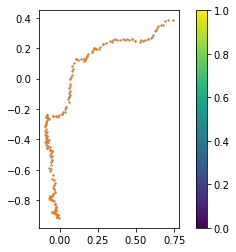

[0. 1. 2.]


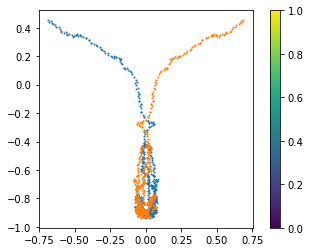

[1. 0. 2.]


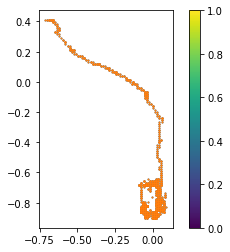

[2. 0. 1.]


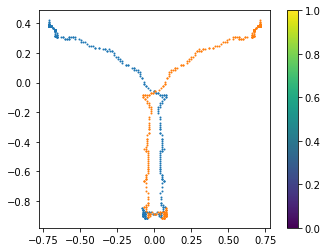

[1. 0. 2.]


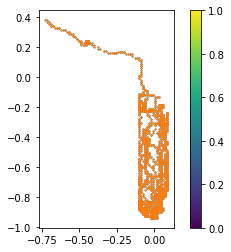

[2. 0. 1.]


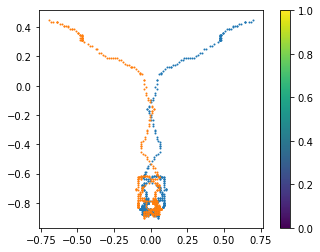

[1. 0. 2.]


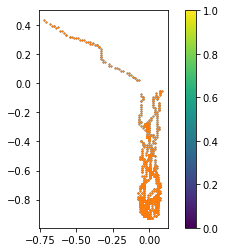

[0. 1. 2.]


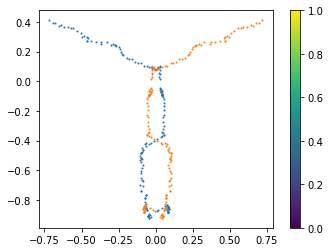

[2. 1. 0.]


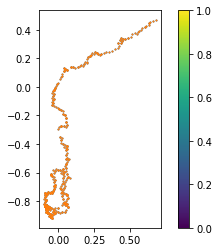

[2. 0. 1.]


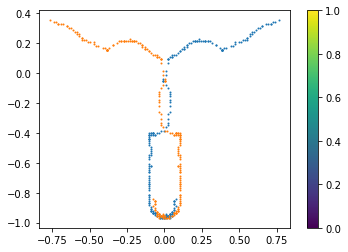

[0. 2. 1.]


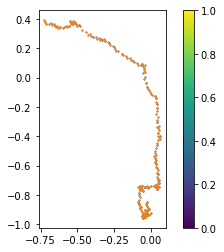

[1. 2. 0.]


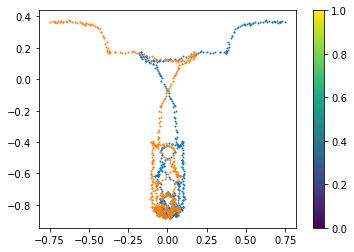

[0. 2. 1.]


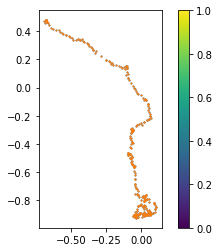

[1. 2. 0.]


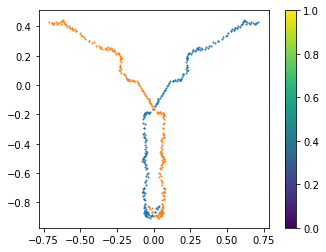

In [92]:
def realign_lr(start_arm,point):
    if start_arm==1.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
    elif start_arm==2.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
    elif start_arm==0.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
    else:
        raise ValueError("start_arm must be 0, 1 or 2")
    return transform(point)

def realign_odor(odor_vector,point):
    if np.all(odor_vector==[1.0, 0.0, 2.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
        return transform(point)
    elif np.all(odor_vector==[2.0, 0.0, 1.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[0.0, 1.0, 2.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[0.0, 2.0, 1.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)
    elif np.all(odor_vector==[1.0, 2.0, 0.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[2.0, 1.0, 0.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)
    else:
        raise ValueError("odor vector must be [1.0, 0.0, 2.0], [2.0, 0.0, 1.0], [0.0, 1.0, 2.0], [0.0, 2.0, 1.0], [1.0, 2.0, 0.0] or [2.0, 1.0, 0.0]")
    

for i in os.listdir("data"):
    if i.endswith(".ydata"):
        with open("data/" + i, "r") as f:
            data = json.load(f)
        # get index of the arena
        index = int(i.split(".")[0].split("_")[-1])
        # get fly position
        fly_position = np.array(data['fly_positions'])
        # switch x and y
        fly_position = fly_position[:, [1, 0]]
        # get the estimated transform
        transform = estimated_transforms[index]
        # add the transformed fly position
        reference_fly_positions = transform(fly_position)
        # calculate instantaneous speed
        speed = np.linalg.norm(np.diff(reference_fly_positions, axis=0),axis=1)/np.diff(data['frame_times'], axis=0)
        # calculate instantaneous heading
        heading = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0))
        # calculate upwind speed
        radial_distance = np.linalg.norm(reference_fly_positions-origin, axis=1)
        upwind_speed = np.diff(radial_distance, axis=0)/np.diff(data['frame_times'], axis=0)
        # calculate upwind orientation
        upwind_orientation = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0)) - \
                            np.arctan2 (reference_fly_positions[:-1,1]-origin[1], reference_fly_positions[:-1,0]-origin[0])
        # calculate current trial
        data['trial_start_times'].append(data['frame_times'][-1])
        current_trials = np.array([np.argmax(data['frame_times'][i] <= np.array(data['trial_start_times'])) for i in range(len(data['frame_times']))])
        current_start_arms = np.array(data['start_arms'])[current_trials-1]
        current_odor_vectors = np.array(data['odor_vectors'])[current_trials-1]
        # calculate trial oriented position
        trial_oriented_position = np.array([realign_lr(current_start_arms[i], reference_fly_positions[i]) for i in range(len(data['frame_times']))]).squeeze()
        # calculate odor oriented position
        odor_oriented_position = np.array([realign_odor(current_odor_vectors[i], reference_fly_positions[i]) for i in range(len(data['frame_times']))]).squeeze()
        # plot the transformed fly position
        plt.scatter(trial_oriented_position[current_trials==5, 0], trial_oriented_position[current_trials==5, 1],s=1)
        plt.scatter(odor_oriented_position[current_trials==5, 0], odor_oriented_position[current_trials==5, 1],s=1)
        print(current_odor_vectors[current_trials==5][0])
        plt.colorbar()
        plt.gca().set_aspect('equal')
        plt.show()

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


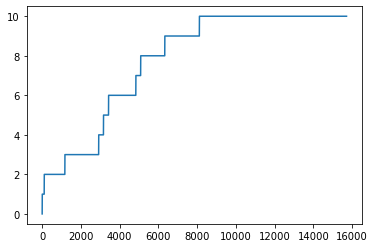

In [51]:
def realign_lr(start_arm,point)
    if start_arm==1.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
    elif start_arm==2.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
    elif start_arm==0.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
    else:
        raise ValueError("start_arm must be 0, 1 or 2")
    return transform(point)
np.array(data['start_arms'])[np.array(current_trials)[1:]-1]

In [46]:
data['trial_start_times']

[1656956532.4554706,
 1656956538.5790334,
 1656956577.4917638,
 1656956639.827301,
 1656956648.7627008,
 1656956657.9949062,
 1656956708.6392543,
 1656956717.496549,
 1656956761.7205312,
 1656956825.6451497]

In [47]:
data['frame_times'][-1]

1656957092.969741